# Optical Character Recognition - Handwriting Recognition

This notebook looks at computer vision techniques for OCR, specifically for handwriting recognition.

Skimming through the data-set provided, we can see that there is a large training sample (> 300K) and the images are gray-scale, with black text on white background. Many of the images have the person writing their name in block letters, which is good since identifying cursive letters is a harder challenge for OCR software.

The dataset seems to have images from a hand-filled form, and we can see that there is also text from the form fields as well (For example, "nom" (which is "Last Name")). This will be a challenge, since the OCR method will pick up these text as well and we will need to filter them out.

Let's look at 4 random images and their corresponding labels below.

In [ ]:
import numpy as np 
import pandas as pd
import os
import string
from unidecode import unidecode
import dill
from IPython.display import Image as IPythonImage, display
from PIL import Image
import pytesseract
from Levenshtein import jaro_winkler
import matplotlib.pyplot as plt

In [ ]:
# Look at the labels
validation_df = pd.read_csv("../input/handwriting-recognition/written_name_validation_v2.csv")
validation_df.head()

In [ ]:
# Display a few randomly chosen images along with their labels
PATH = '../input/handwriting-recognition/validation_v2/validation'

# Print randomly selected images and their labels
NUMBER_OF_IMAGES = 4
random_index = np.random.choice(validation_df.shape[0], NUMBER_OF_IMAGES, False)
for row in validation_df.loc[random_index, :].itertuples(index=False):
    filename = os.path.join(PATH, row.FILENAME)
    print(row.IDENTITY)
    display(IPythonImage(filename=filename))

## Baseline model using Tesseract-OCR

OCR has been actively researched since long before the resurgence of deep learning. Accordingly, there are solutions that use no deep learning at all, and use classical computer vision approaches.

The [Tesseract Project](https://github.com/tesseract-ocr/tesseract) is an open source OCR project that started in 1985 in HP labs. In 2006, HP handed over the project to Google.

The current version of Tesseract, Tesseract 4.0, uses a blended pipeline of computer vision and deep learning, utilizing an LSTM model to detect text lines in the image. 

Here is how the pipeline looks like (taken from a [2016 talk by Google engineers](https://github.com/tesseract-ocr/docs/blob/master/das_tutorial2016/2ArchitectureAndDataStructures.pdf) on the Tesseract internals):

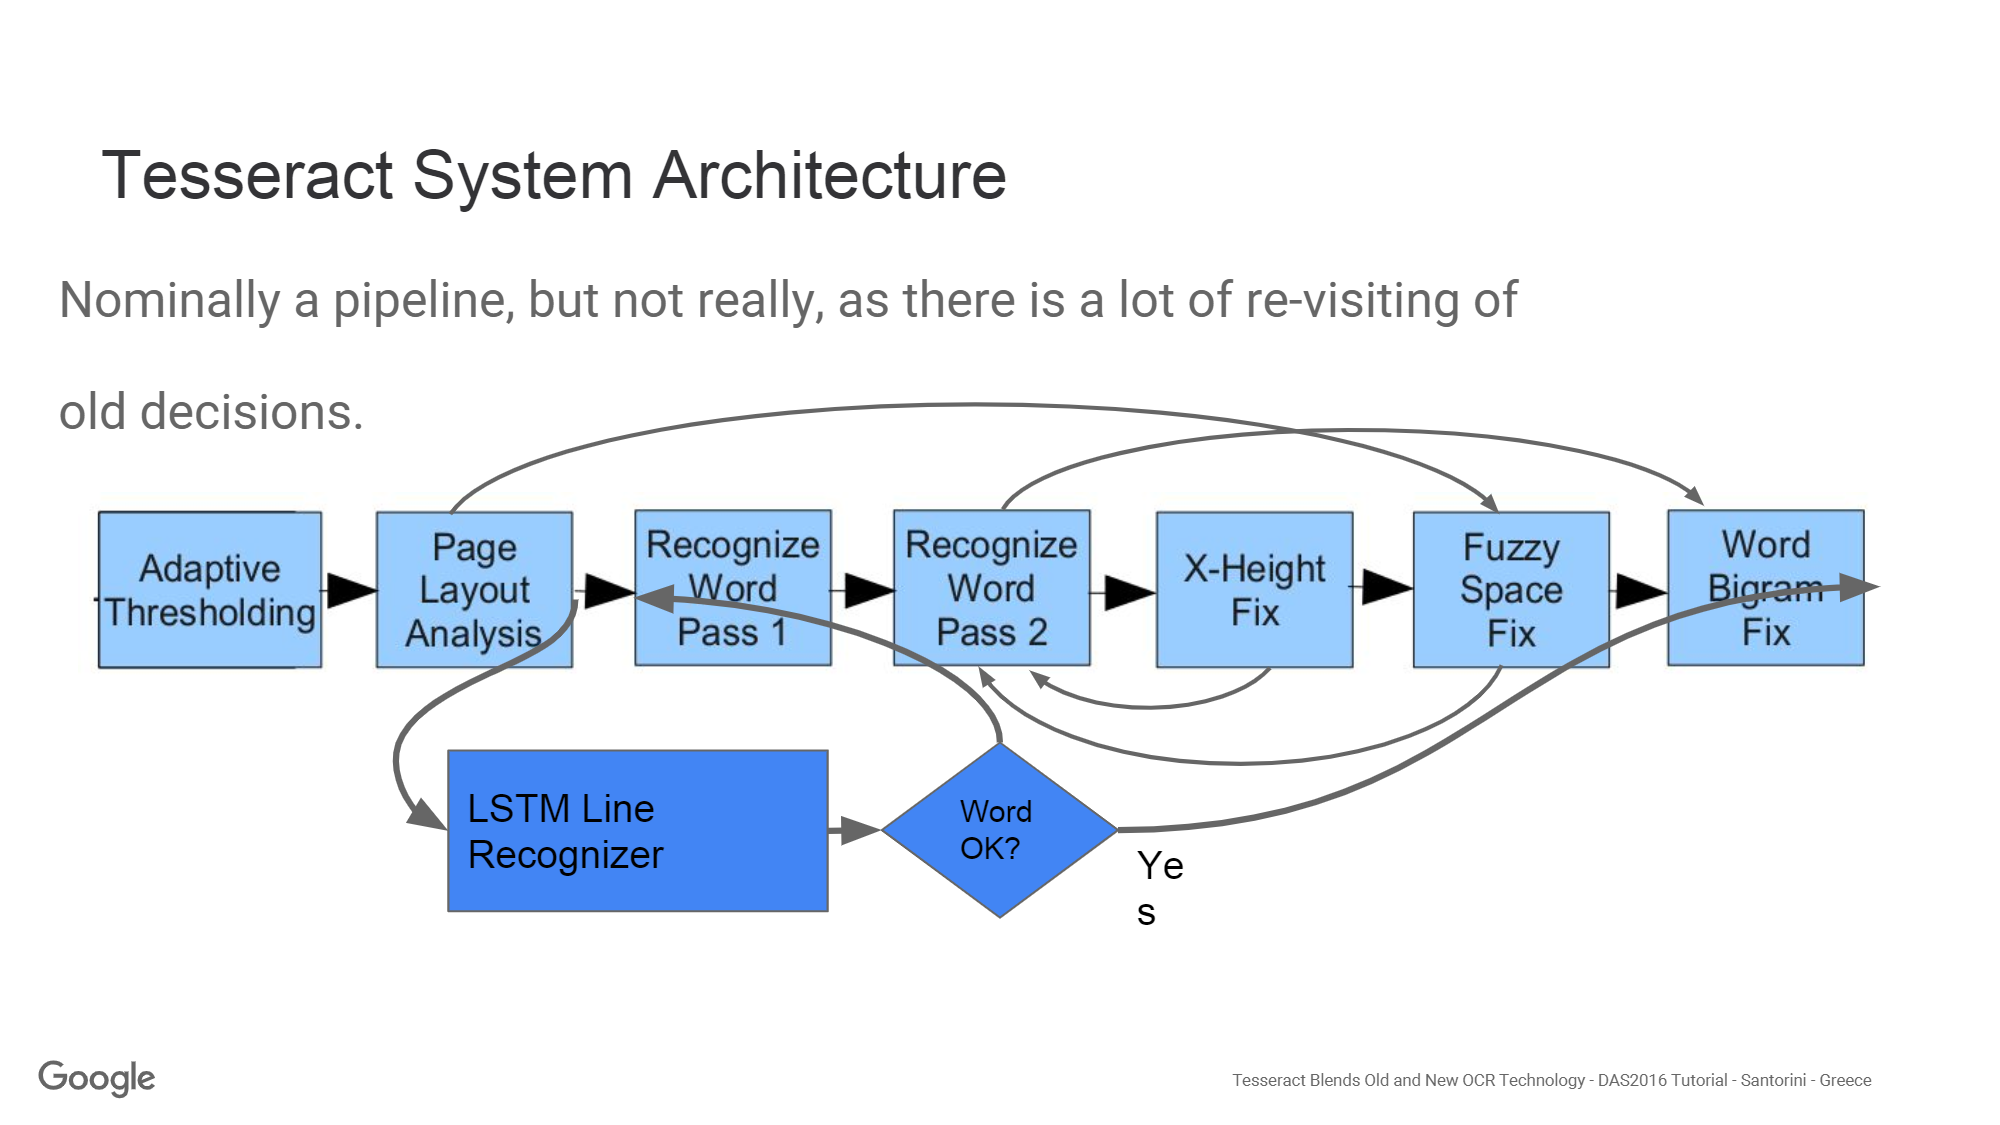

In fact, I was surprised to discover that **the Tesseract project implemented an LSTM model before TensorFlow**! Details are present [here](https://github.com/tesseract-ocr/docs/blob/master/das_tutorial2016/6ModernizationEfforts.pdf) (navigate to the section called "What about TensorFlow")

For the baseline model, I will be using PyTesseract, which is a Python binding to the Tesseract API. I won't actually be training a model, since Tesseract comes fully loaded and is supposed to work out-of-the-box. They do provide an API to train an OCR model, which I will explore in a later iteration.

In [ ]:
# Iterate over the data-frame, running Tesseract OCR and recording the output of Tesseract
# Takes a fair bit of time (2 hours)
output = {}
for row in validation_df.itertuples():
    file_path = os.path.join(PATH, row.FILENAME)
    image = Image.open(file_path)
    text = pytesseract.image_to_string(image)
    output[row.FILENAME] = text
    if ((row.Index + 1) % 5000) == 0:
        print(f"Processed {row.Index + 1} rows")

In [ ]:
# Convert into df
result_df = pd.DataFrame()
for i, (k, v) in enumerate(output.items()):
    if (i + 1) % 5000 == 0:
        print(f"Converted output from {i + 1} images")
    
    text = [t for t in v.split('\n') if t not in ['', ' ', '\n', '\x0c']]
    
    temp_df = pd.DataFrame({
        'FILENAME': [k] * len(text), 
        'TEXT': text
    })
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

# Look at the top 10 text tokens (these will probably be generic terms like "nom")
result_df['TEXT'].value_counts().nlargest(10)

We see, from the most frequent text tokens, that there's a secondary problem of removing the ancilliary text (form field data). 

Ideally, we would adopt an approach based on how "centered" a text segment is in the image:
1. Create bounding boxes for all words
2. Keep words that are in bounding boxes near the center of the image
3. Also filter out any common words (like "Nom", "Prenom" etc)

The Tesseract software provides support for returning the bounding boxes of text read from images. 

My current implementation doesn't take advantage of that yet, however, so I will implement step 3 only (for now).

In [ ]:
# Filter and get possible variations of "Nom", "Prenom" etc
result_df\
    .loc[result_df['TEXT'].str.upper().str.contains('NOM|PRENOM|DATE DE NAISSANCE CLASSE') , "TEXT"]\
    .head(30)

It looks like handling these common words is going to be a bit of a pain. 

Here's 1 strategy:

1. Tokenize based on spaces
2. For each token, if these common words form a substring, then delete the word
3. If a token is a special character (like ":" or "=") delete it (since it's probably not someone's name)
4. Recombine remaining tokens separated by space

Examples:

1. "NOM: DEBRRD" -> "DEBRRD" (Delete 'NOM:' and keep the rest of the text)
2. "NOM: = FAURE" -> "FAURE" (Delete 'NOM:' as well as '=')

In [ ]:
# Helper function to remove tokens that are common words and stand-alone punctuation
def filter_tokens(token_list, tokens_to_filter, remove_punctuation = True):
    # Punctuation and empty text
    punctuation_list = list(string.punctuation) + ['']
    result = []
    for t in token_list:
        # Remove stand-alone punctuation/empty string
        # Unicode has some fancy punctuation marks (slanting quotes, for example)
        # remove them using unidecode
        if remove_punctuation and unidecode(t) in punctuation_list:
            continue
        
        # Remove if any token in tokens_to_filter list is a substring of current token
        found = 0
        for t_filter in tokens_to_filter:
            if t_filter.upper() in t.upper():
                # token is matched in tokens_to_filter list
                found = 1
                break
        
        if found == 1:
            continue
        else:
            result.append(t)
    
    return result


# Define text to remove
SINGLE_TOKENS_REMOVE = ['NOM', 'PRENOM']
MULTI_TOKENS_REMOVE = ['DATE DE NAISSANCE CLASSE']

# Remove tokens
result_df['CLEAN_TEXT'] = result_df['TEXT']\
    .str\
    .split(' ')\
    .apply(lambda c: ' '.join(filter_tokens(c, SINGLE_TOKENS_REMOVE)))

for multi_token in MULTI_TOKENS_REMOVE:
    result_df['CLEAN_TEXT'] = np.where(result_df['CLEAN_TEXT'].str.contains(multi_token), 
                                       '', 
                                       result_df['CLEAN_TEXT'])

result_df.head(40)

In [ ]:
# Combine remaining multiple words into 1 (per filename)
clean_result = result_df\
    .groupby('FILENAME')['CLEAN_TEXT']\
    .apply(''.join)\
    .reset_index()

clean_result.head(20)

### Baseline Performance using Text-Similarity Metrics

For computing the performance, I will be using the [Jaro-Winkler algorithm](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance) to detect similarity between the captured text and the actual text.

This is necessary because OCR is a hard task, and we don't want to mark a near-miss (maybe because there's a mismatch in 1 character) as a failure. This also allows us to get a quantitative understanding of how good our OCR system is.

In [ ]:
# Create 1 dataframe with both actual and OCR labels
ocr_vs_actual = validation_df.merge(clean_result, how='left', on='FILENAME')

# Remove labels which do not exist
ocr_vs_actual = ocr_vs_actual.loc[ocr_vs_actual['IDENTITY'].notnull(), :]

# Remove spaces in OCR output
ocr_vs_actual['CLEAN_TEXT'] = ocr_vs_actual['CLEAN_TEXT'].str.replace('\\s', '', regex=True)
ocr_vs_actual.head(10)

In [ ]:
# Create jaro-winkler similarity score
vectorized_jaro_winkler = np.vectorize(jaro_winkler)

ocr_vs_actual['SIMILARITY_SCORE'] = vectorized_jaro_winkler(ocr_vs_actual['IDENTITY'].str.upper(), 
                                                            np.where(ocr_vs_actual['CLEAN_TEXT'].isnull(), 
                                                                     '', 
                                                                     ocr_vs_actual['CLEAN_TEXT'].str.upper()))
ocr_vs_actual.head(10)

Looking at the first 10 data points, it looks like results with high similarity score are pretty good.

Let's plot the distribution of the similarity score to quickly see how we did on the whole population.

In [ ]:
# Plot histogram of similarity scores to see how well we did
plt.style.use('seaborn-white')
plt.figure(figsize=(8,3), dpi=120)
plt.hist(ocr_vs_actual['SIMILARITY_SCORE'], bins=50, alpha=0.5, color='steelblue', edgecolor='none')
plt.title('Histogram of Jaro-Winkler similarity score between label and OCR-results')
plt.show()

The results seem OK for a baseline approach, using out-of-the-box software. 13K high quality results out of 42K (30% success rate).

Let's create bins based on the similarity score and sample a few images to see how we did. The goal is to see how hard the image actually was, for the OCR model to make mistakes.

In [ ]:
# Create bins. Non-uniform width.
second_lowest_score = ocr_vs_actual.loc[(ocr_vs_actual['SIMILARITY_SCORE'] != 0), 'SIMILARITY_SCORE'].min()

ocr_vs_actual['BINS'] = pd.cut(ocr_vs_actual['SIMILARITY_SCORE'], 
                               bins=[0] + np.linspace(second_lowest_score, 0.95, 9).tolist() + [0.96, 0.97, 0.98, 0.99, 1.01], 
                               labels = ['no-match', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'best-match'],
                               right=False)
ocr_vs_actual['BINS'].value_counts().sort_index()

In [ ]:
# Highest similarity score images
NUMBER_OF_IMAGES = 5
random_filename = np.random.choice(ocr_vs_actual.loc[ocr_vs_actual['BINS'] == 'best-match', 'FILENAME'].tolist(), NUMBER_OF_IMAGES, False)
for row in ocr_vs_actual.loc[ocr_vs_actual['FILENAME'].isin(random_filename), :].itertuples(index=False):
    filename = os.path.join(PATH, row.FILENAME)
    print(f"""Filename: {row.FILENAME}\nActual: {row.IDENTITY}\nOCR: {row.CLEAN_TEXT}""")
    display(IPythonImage(filename=filename))

In [ ]:
# Mid-range similarity score images
NUMBER_OF_IMAGES = 5
random_filename = np.random.choice(ocr_vs_actual.loc[ocr_vs_actual['BINS'] == '8', 'FILENAME'].tolist(), NUMBER_OF_IMAGES, False)
for row in ocr_vs_actual.loc[ocr_vs_actual['FILENAME'].isin(random_filename), :].itertuples(index=False):
    filename = os.path.join(PATH, row.FILENAME)
    print(f"""Filename: {row.FILENAME}\nActual: {row.IDENTITY}\nOCR: {row.CLEAN_TEXT}""")
    display(IPythonImage(filename=filename))

In [ ]:
# No matches
NUMBER_OF_IMAGES = 5
random_filename = np.random.choice(ocr_vs_actual.loc[ocr_vs_actual['BINS'] == 'no-match', 'FILENAME'].tolist(), NUMBER_OF_IMAGES, False)
for row in ocr_vs_actual.loc[ocr_vs_actual['FILENAME'].isin(random_filename), :].itertuples(index=False):
    filename = os.path.join(PATH, row.FILENAME)
    print(f"""Filename: {row.FILENAME}\nActual: {row.IDENTITY}\nOCR: {row.CLEAN_TEXT}""")
    display(IPythonImage(filename=filename))

## Summary of the Tesseract approach

Tesseract is, possibly, the most mature open-source OCR software with a focus on working well out-of-the-box and using classical CV, modern DL techniques, as well as language models to correct common parsing errors. 

However, it looks like OCR is still not a fully solved problem especially for hand-written text. 

Analysis of the OCR results show that even easy-to-read hand-written text (easy for me to read, at least) still suffer from false parsing.

I will explore this problem further in later iterations of the notebook.